# CNN on the Cats and Dogs dataset

## Dataset download

In [1]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip -O cats-and-dogs.zip

--2023-12-29 05:06:26--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.199.6.55, 2600:1406:3400:785::317f, 2600:1406:3400:799::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.199.6.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘cats-and-dogs.zip’

cats-and-dogs.zip   100%[===================>] 786.67M   173MB/s    in 5.0s    

2023-12-29 05:06:31 (158 MB/s) - ‘cats-and-dogs.zip’ saved [824887076/824887076]



In [6]:
!unzip -q cats-and-dogs.zip -d cats-and-dogs-folder

## Data Preprocessing

### Removing Corrupt image files

In [7]:
import os
import PIL.Image

def remove_corrupt_images(dataset_path):
  """Removes corrupt image files from a dataset.

  Args:
    dataset_path: The path to the dataset.

  Returns:
    A dictionary with the valid image files.
  """

  dataset = {}
  for filename in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, filename)
    try:
      image = PIL.Image.open(image_path)
      dataset[filename] = image
    except PIL.UnidentifiedImageError:
      print("Corrupt image file:", image_path)
      os.remove(image_path)

  return dataset

catdataset = remove_corrupt_images("./cats-and-dogs-folder/PetImages/Cat")
dogdataset = remove_corrupt_images("./cats-and-dogs-folder/PetImages/Dog")

Corrupt image file: ./cats-and-dogs-folder/PetImages/Cat/Thumbs.db
Corrupt image file: ./cats-and-dogs-folder/PetImages/Cat/666.jpg
Corrupt image file: ./cats-and-dogs-folder/PetImages/Dog/Thumbs.db


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupt image file: ./cats-and-dogs-folder/PetImages/Dog/11702.jpg


In [18]:
! ls ./cats-and-dogs-folder/PetImages/Dog/ -l | grep .db

In [19]:
import os
import matplotlib.pyplot as plt

CATS_PATH = './cats-and-dogs-folder/PetImages/Cat/'
DOGS_PATH = './cats-and-dogs-folder/PetImages/Dog/'

cats_data = os.listdir(CATS_PATH)
dogs_data = os.listdir(DOGS_PATH)

print(type(cats_data), len(cats_data))
print(type(dogs_data), len(dogs_data))

<class 'list'> 12499
<class 'list'> 12499


### Plotting random images here

['311.jpg', '5670.jpg', '5300.jpg', '6013.jpg', '8640.jpg', '10998.jpg', '8232.jpg', '3699.jpg', '436.jpg', '6889.jpg']
['311.jpg', '5670.jpg', '5300.jpg', '6013.jpg', '8640.jpg', '10998.jpg', '8232.jpg', '3699.jpg', '436.jpg', '6889.jpg']


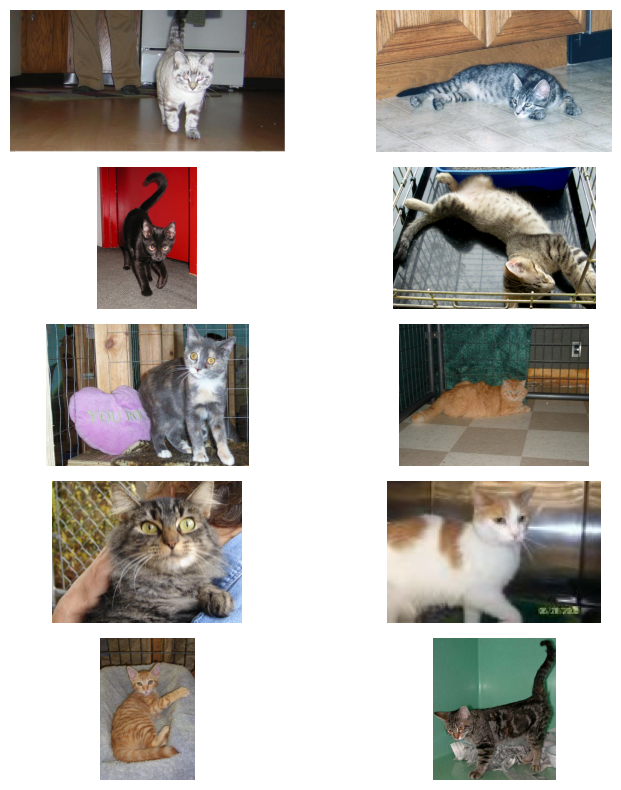

In [20]:
%matplotlib inline
from skimage import io
from random import randint

indx = randint(0, len(cats_data) - 10)
rand_cat = cats_data[indx:indx+10]
rand_dog = dogs_data[indx:indx+10]

print(rand_cat)
print(rand_dog)

fig, axes = plt.subplots(5,2)
fig.set_size_inches(8,8)

for i, ax in enumerate(axes.flat) :
    img = io.imread(os.path.join(CATS_PATH, rand_cat[i]))
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

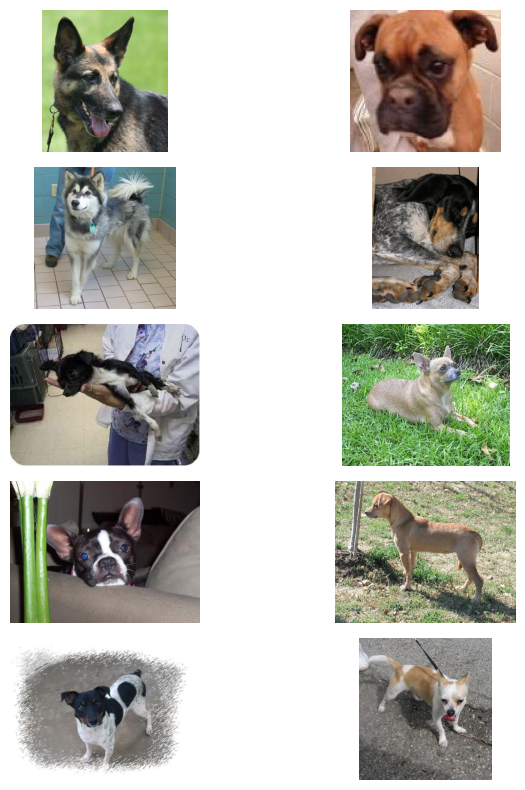

In [21]:
fig, axes = plt.subplots(5,2)
fig.set_size_inches(8,8)

for i, ax in enumerate(axes.flat) :
    img = io.imread(os.path.join(DOGS_PATH, rand_dog[i]))
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Loading Data generator here

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

train_gen = data_gen.flow_from_directory(
    './cats-and-dogs-folder/PetImages/',
    batch_size=64,
    target_size=(256,256),
    class_mode='binary',
    subset='training'
)

valid_gen = data_gen.flow_from_directory(
    './cats-and-dogs-folder/PetImages/',
    batch_size=16,
    target_size=(256,256),
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


## Model Declaration

In [40]:
import tensorflow as tf
import numpy as np

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Conv2D(32,(5,5),activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Conv2D(32,(5,5),activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 84, 84, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 32)        25632     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 7, 7, 32)         

In [42]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

### Model training

In [43]:
train_hist = model.fit(train_gen, validation_data=valid_gen, epochs=20)

Epoch 1/20
145/313 [============>.................] - ETA: 36s - loss: 0.6786 - accuracy: 0.5590

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 84s 261ms/step - loss: 0.6204 - accuracy: 0.6348 - val_loss: 0.5185 - val_accuracy: 0.7517
Epoch 2/20
313/313 [==============================] - 81s 259ms/step - loss: 0.4853 - accuracy: 0.7674 - val_loss: 0.4988 - val_accuracy: 0.7555
Epoch 3/20
313/313 [==============================] - 81s 257ms/step - loss: 0.4103 - accuracy: 0.8131 - val_loss: 0.4015 - val_accuracy: 0.8221
Epoch 4/20
313/313 [==============================] - 83s 265ms/step - loss: 0.3563 - accuracy: 0.8396 - val_loss: 0.3956 - val_accuracy: 0.8215
Epoch 5/20
313/313 [==============================] - 82s 262ms/step - loss: 0.3069 - accuracy: 0.8682 - val_loss: 0.3817 - val_accuracy: 0.8217
Epoch 6/20
313/313 [==============================] - 75s 239ms/step - loss: 0.2584 - accuracy: 0.8885 - val_loss: 0.3672 - val_accuracy: 0.8491
Epoch 7/20
313/313 [==============================] - 78s 250ms/step - loss: 0.2106 - accuracy: 0.9130 - val_loss: 0.3298 - val_accuracy: 0.8

## Validation check

In [30]:
# val_hist = model.evaluate(valid_gen)

313/313 [==============================] - 13s 40ms/step - loss: 0.4495 - accuracy: 0.8437


In [33]:
# val_hist

[0.44945135712623596, 0.8437374830245972]

## Plotting both training metrics

In [47]:
print(train_hist.history)
print(train_hist.history.keys())

{'loss': [0.6204091906547546, 0.48527762293815613, 0.4102754294872284, 0.35625123977661133, 0.3068695664405823, 0.2584167718887329, 0.21059025824069977, 0.16678887605667114, 0.12706200778484344, 0.09277381747961044, 0.07028131932020187, 0.049859534949064255, 0.04477677121758461, 0.037956129759550095, 0.03351930156350136, 0.030617916956543922, 0.027212325483560562, 0.02639027312397957, 0.022542519494891167, 0.018998699262738228], 'accuracy': [0.6348000168800354, 0.7674000263214111, 0.8131499886512756, 0.8395500183105469, 0.8682000041007996, 0.8885499835014343, 0.9130499958992004, 0.9343000054359436, 0.949999988079071, 0.9649500250816345, 0.9741500020027161, 0.9833999872207642, 0.9840999841690063, 0.9882500171661377, 0.9904500246047974, 0.991100013256073, 0.9918000102043152, 0.9916499853134155, 0.9929999709129333, 0.9944499731063843], 'val_loss': [0.5185456275939941, 0.49876004457473755, 0.4014833867549896, 0.3956165909767151, 0.3817451298236847, 0.36721381545066833, 0.32977962493896484,

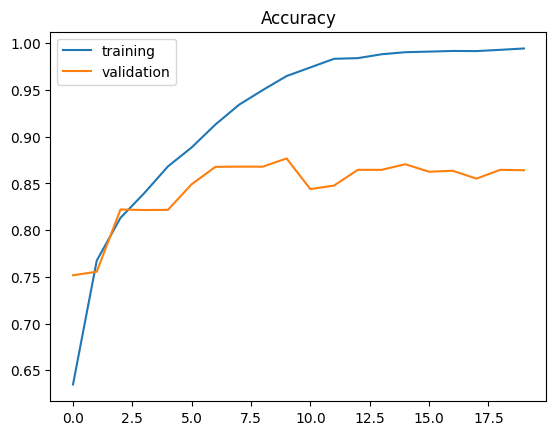

In [50]:
plt.plot(train_hist.history['accuracy'], label='training')
plt.plot(train_hist.history['val_accuracy'], label='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

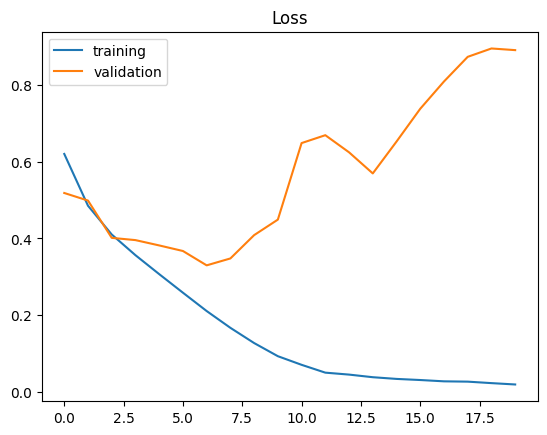

In [51]:
plt.plot(train_hist.history['loss'], label='training')
plt.plot(train_hist.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

The graphs suggest that epoch 7 is the where the model was most accurate for validation data implying that it performs best on real world data at 86.77% accuracy

## Checking on random images

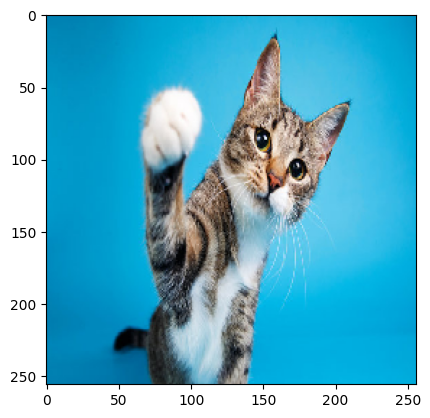

In [71]:
from tensorflow.keras.utils import load_img, img_to_array

rand_img = load_img('./random-images/cat.jpeg', target_size=(256,256))
rand_img = img_to_array(rand_img) / 255

plt.imshow(rand_img)

In [72]:
train_gen.class_indices

{'Cat': 0, 'Dog': 1}

In [73]:
output_class = model.predict(rand_img.reshape(1,256,256,3))
print(output_class)
if output_class[0] > 0.5:
  print(f'The image is {output_class[0]*100}% Dog')
else:
  print(f'The image is {(1 - output_class[0])*100}% Cat')

1/1 [==============================] - 0s 21ms/step
[[0.0087744]]
The image is [99.12256]% Cat


## Saving entire keras model

In [74]:
model.save('cat-dog-model.keras')

## Viewing intermediate layers

In [107]:
rand_indx = randint(0,len(cats_data))
rand_animal = dogs_data[rand_indx]

rand_img = load_img(os.path.join(DOGS_PATH,rand_animal), target_size=(256,256))
rand_img = img_to_array(rand_img)

1/1 [==============================] - 0s 80ms/step
[<KerasTensor: shape=(None, 254, 254, 32) dtype=float32 (created by layer 'conv2d_6')>, <KerasTensor: shape=(None, 84, 84, 32) dtype=float32 (created by layer 'max_pooling2d_6')>, <KerasTensor: shape=(None, 80, 80, 32) dtype=float32 (created by layer 'conv2d_7')>, <KerasTensor: shape=(None, 26, 26, 32) dtype=float32 (created by layer 'max_pooling2d_7')>, <KerasTensor: shape=(None, 22, 22, 32) dtype=float32 (created by layer 'conv2d_8')>, <KerasTensor: shape=(None, 7, 7, 32) dtype=float32 (created by layer 'max_pooling2d_8')>, <KerasTensor: shape=(None, 1568) dtype=float32 (created by layer 'flatten_2')>, <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense_4')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>]
<class 'numpy.ndarray'> (1, 254, 254, 32)
<class 'numpy.ndarray'> (1, 84, 84, 32)
<class 'numpy.ndarray'> (1, 80, 80, 32)
<class 'numpy.ndarray'> (1, 26, 26, 32)
<class 'numpy.ndarray'

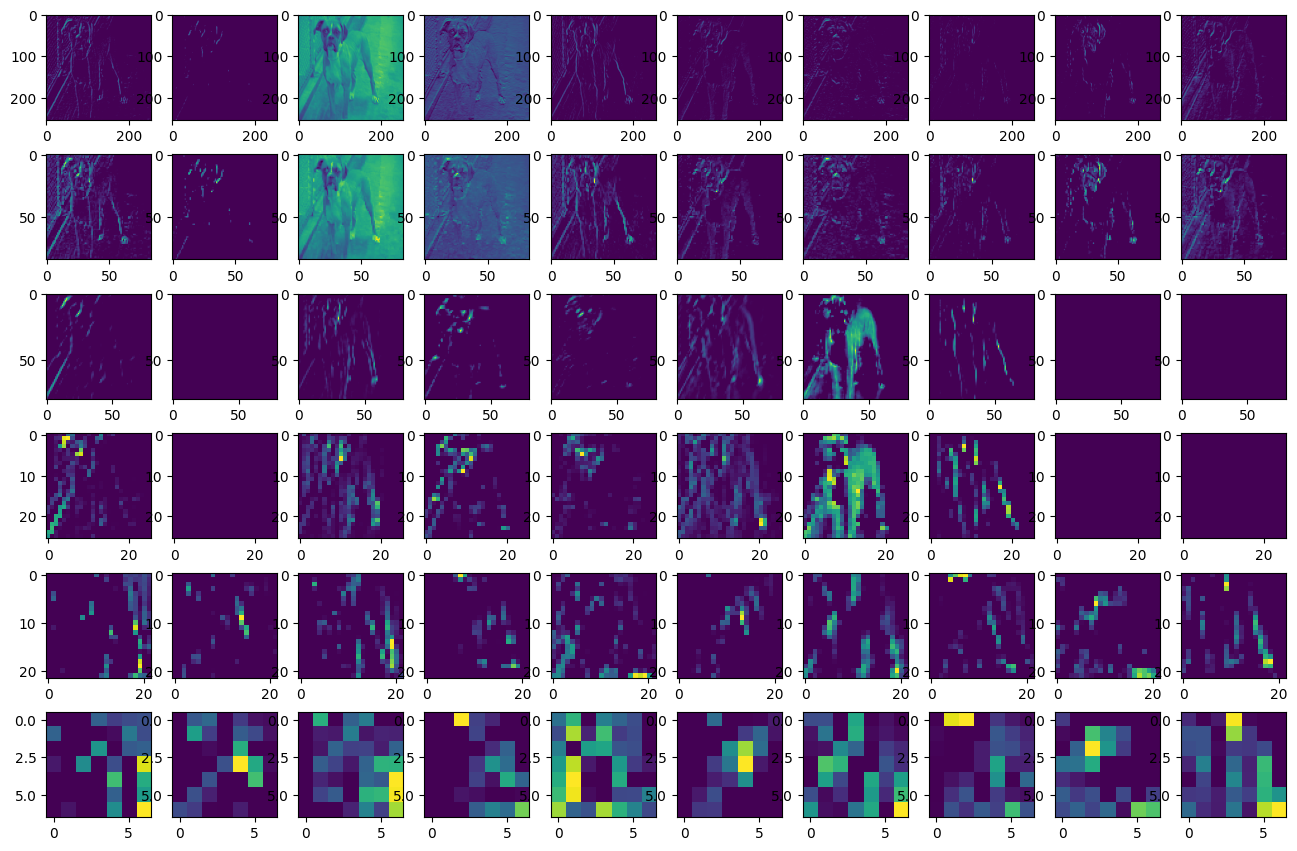

In [108]:
layer_outputs = [layer.output for layer in model.layers]
layer_names = [layer.name for layer in model.layers]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

feature_maps = visualization_model.predict(rand_img.reshape(1,256,256,3))
print(layer_outputs)

i = 1

#
#
fig = plt.gcf()
fig.set_size_inches(16,16)

for lname, lmap in zip(layer_names, feature_maps):
  print(type(lmap), lmap.shape)

  if len(lmap.shape) == 4:
    for j in range(10):
      map_image = lmap[0,:,:,j]
      plt.subplot(len(feature_maps),10,i)
      plt.imshow(map_image)
      i+=1

plt.show()